# Projeto 1
## Introdução a Data Science
### Alunos
Gabriel de Melo Evangelista (gme@cin.ufpe.br)

Maria Luísa Leandro de Lima (mlll@cin.ufpe.br)
### Tema: Powerlifting
https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

- Comparação: Pesos levantados por homem/mulher, raw/singleply, 2 grupos de idade

- ver a diferença de performance de uma pessoa com os anos

- discretizar os pesos usados em exercicios pra dps categorizar usar pra alguma coisa
  - colocar uma coluna pra flag de exercicio falho e remover o sinal negativo da coluna original

- o peso que as pessoas conseguem executar o exercicio é menor que o peso que eles falham

- ver se tem impacto ser tested ou n

- ajeitar a idade bugada pra zero
  
- Criar um plot com o peso levantado com melhores dos equipamentos, separando por idade
  
- Criar um plot com as 4 tentativas de levantamento para ver a melhoria das pessoas

### Imports

Aqui são feitos os imports das bibliotecas utilizadas

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error as mse

### 1. Coleta de dados

In [74]:
df = pd.read_csv('openpowerlifting.csv')

c:\Users\GODZILLA\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (33,35,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [75]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Tested,Country,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName
0,Alona Vladi,F,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
1,Galina Solovyanova,F,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
2,Daniil Voronin,M,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
3,Aleksey Krasov,M,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament
4,Margarita Pleschenkova,M,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,Yes,Russia,NaN,GFP,NaN,2019-05-11,Russia,NaN,Bryansk,Open Tournament


In [76]:
df.shape

(2744390, 41)

Observamos que os dados tem cerca de 2.7 milhões de entradas com 41 colunas.

In [77]:
df.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass',
       'BirthYearClass', 'Division', 'BodyweightKg', 'WeightClassKg',
       'Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Best3SquatKg',
       'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Best3BenchKg',
       'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg',
       'Best3DeadliftKg', 'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner',
       'Goodlift', 'Tested', 'Country', 'State', 'Federation',
       'ParentFederation', 'Date', 'MeetCountry', 'MeetState', 'MeetTown',
       'MeetName'],
      dtype='object')

Vamos analisar algumas das colunas para que possamos filtrar nossos dados

A coluna de "Event" indica o tipo de competição que o levantador participou. 

Os valores podem ser:

* SBD: Agachamento, Supino e Deadlift
* BD: Supino e Deadlift
* SD: Agachamento e Deadlift
* SB: Agachamento e Supino
* S: Apenas Agachamento
* B: Apenas Supino
* D: Apenas Deadlift



In [78]:
df['Event'].value_counts()

SBD    1886059
B       627304
D       157510
BD       53965
S        14886
SB        2876
SD        1790
Name: Event, dtype: int64

Observa-se que a maior parte dos eventos foi do tipo mais completo, decidiu-se então seguir apenas com o evento SBD.

A coluna Equipment indica a categoria do equipamento em que os levantamentos foram feitos.

Os valores podem ser:

* Raw: Sem equipamentos
* Wraps: Faixas de joelho são permitidas
* Single-ply: Macacão de powerlifting
* Multi-ply: Macacão com outros acessórios
* Unlimited: Quaisquer equipamento pode ser utilizado
* Straps: Straps para deadlift

In [79]:
df['Equipment'].value_counts()

Single-ply    1312406
Raw           1127258
Wraps          177562
Multi-ply      119583
Unlimited        7535
Straps             46
Name: Equipment, dtype: int64

Observa-se que a maior parte dos eventos são com Single-ply e Raw por isso decidiu-se seguir apenas com esses 2.

A coluna de Posição não possui apenas números, podendo possuir as seguintes categorias:

* DQ: Desclassificado
* NS: Não participou
* G: Participante convidado
* DD: Desclassificado por doping

In [80]:
df[~df['Place'].str.isnumeric()]['Place'].value_counts()

DQ    173956
NS     14671
G       7461
DD      1506
Name: Place, dtype: int64

Como há apenas interesse na posição numérica dos participantes, é feita a retirada de tais categorias.

In [81]:
df = df[(df['Place'].str.isnumeric()) & (df['Event']=='SBD') & (df['Equipment'].isin(['Single-ply', 'Raw']))]

Além disso como não há interesse nas seguintes colunas, elas serão removidas.

In [82]:
df = df.drop(['Date','Federation', 'MeetName','MeetCountry','MeetState','MeetTown','Tested'], axis=1)

In [83]:
df.shape

(1522738, 34)

Com estes cortes, os dados passaram a ter cerca 1.5 milhões de linhas

In [84]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Best3DeadliftKg,TotalKg,Place,Dots,Wilks,Glossbrenner,Goodlift,Country,State,ParentFederation
0,Alona Vladi,F,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,107.5,247.5,1,279.44,282.18,249.42,57.10,Russia,NaN,NaN
1,Galina Solovyanova,F,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,110.0,282.5,1,278.95,272.99,240.35,56.76,Russia,NaN,NaN
2,Daniil Voronin,M,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,105.0,267.5,1,206.40,206.49,200.45,41.24,Russia,NaN,NaN
3,Aleksey Krasov,M,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,170.0,430.0,1,334.49,334.94,325.32,66.68,Russia,NaN,NaN
4,Margarita Pleschenkova,M,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,125.0,265.0,1,194.46,193.55,187.29,39.34,Russia,NaN,NaN


### 2. Pré-processamento dos dados

#### 2.1 Análise

##### 2.1.1 Definição de tipos

In [85]:
df.dtypes

Name                 object
Sex                  object
Event                object
Equipment            object
Age                 float64
AgeClass             object
BirthYearClass       object
Division             object
BodyweightKg        float64
WeightClassKg        object
Squat1Kg            float64
Squat2Kg            float64
Squat3Kg            float64
Squat4Kg            float64
Best3SquatKg        float64
Bench1Kg            float64
Bench2Kg            float64
Bench3Kg            float64
Bench4Kg            float64
Best3BenchKg        float64
Deadlift1Kg         float64
Deadlift2Kg         float64
Deadlift3Kg         float64
Deadlift4Kg         float64
Best3DeadliftKg     float64
TotalKg             float64
Place                object
Dots                float64
Wilks               float64
Glossbrenner        float64
Goodlift            float64
Country              object
State                object
ParentFederation     object
dtype: object

Percebe-se que há diversas colunas com tipo "object", portanto é feita a troca para categoria e a criação de novas colunas com os valores traduzidos para códigos.

In [86]:
df['Sex'] = df['Sex'].astype('category')
df['Equipment'] = df['Equipment'].astype('category')
df['Division'] = df['Division'].astype('category')
df['WeightClassKg'] = df['WeightClassKg'].astype('category')
df['Place'] = df['Place'].astype('category')
df['Name'] = df['Name'].astype('category')

In [87]:
df['Sex'] = df['Sex'].cat.codes
df['EquipmentC'] = df['Equipment'].cat.codes
df['DivisionC'] = df['Division'].cat.codes
df['WeightClassKgC'] = df['WeightClassKg'].cat.codes
df['PlaceC'] = df['Place'].cat.codes
df['NameC'] = df['Name'].cat.codes

In [88]:
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Glossbrenner,Goodlift,Country,State,ParentFederation,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC
0,Alona Vladi,0,SBD,Raw,33.0,24-34,24-39,O,58.30,60,...,249.42,57.10,Russia,NaN,NaN,0,1865,138,0,23976
1,Galina Solovyanova,0,SBD,Raw,43.0,40-44,40-49,M1,73.10,75,...,240.35,56.76,Russia,NaN,NaN,0,1196,189,0,165932
2,Daniil Voronin,1,SBD,Raw,15.5,16-17,14-18,T,67.40,75,...,200.45,41.24,Russia,NaN,NaN,0,2171,189,0,114094
3,Aleksey Krasov,1,SBD,Raw,35.0,35-39,24-39,O,66.65,75,...,325.32,66.68,Russia,NaN,NaN,0,1865,189,0,15365
4,Margarita Pleschenkova,1,SBD,Raw,26.5,24-34,24-39,O,72.45,75,...,187.29,39.34,Russia,NaN,NaN,0,1865,189,0,300972


##### 2.1.2 Tratamento de dados ausentes

In [89]:
df.isna().sum(axis=0)

Name                      0
Sex                       0
Event                     0
Equipment                 0
Age                  726249
AgeClass             551205
BirthYearClass       681413
Division               1173
BodyweightKg          11885
WeightClassKg          8586
Squat1Kg             989817
Squat2Kg             994541
Squat3Kg            1007495
Squat4Kg            1519175
Best3SquatKg           9331
Bench1Kg             989986
Bench2Kg             993814
Bench3Kg            1007523
Bench4Kg            1519683
Best3BenchKg           9315
Deadlift1Kg          989600
Deadlift2Kg          996298
Deadlift3Kg         1015185
Deadlift4Kg         1516988
Best3DeadliftKg        9277
TotalKg                   0
Place                     0
Dots                  11885
Wilks                 11885
Glossbrenner          11885
Goodlift              12790
Country              799232
State               1213230
ParentFederation     581936
EquipmentC                0
DivisionC           

Observa-se que no dataset há uma grande quantidade de dados ausentes, como há uma grande quantidade de linhas é feita a remoção de colunas com mais de 70% de dados ausentes.
Porém, a coluna de idade será importante para as hipóteses, portanto é feita sua recolocação.

In [90]:
dfnaclean = df.dropna(thresh=0.7*len(df), axis=1)
dfnaclean['Age'] = df['Age']

<ipython-input-90-f8eb11064e68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnaclean['Age'] = df['Age']


In [91]:
dfnaclean.shape

(1522738, 22)

Os dados passaram a ter 29 colunas.

In [92]:
dfnaclean.head()

,Name,Sex,Event,Equipment,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,...,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,Age
0,Alona Vladi,0,SBD,Raw,O,58.30,60,80.0,60.0,107.5,...,279.44,282.18,249.42,57.10,0,1865,138,0,23976,33.0
1,Galina Solovyanova,0,SBD,Raw,M1,73.10,75,105.0,67.5,110.0,...,278.95,272.99,240.35,56.76,0,1196,189,0,165932,43.0
2,Daniil Voronin,1,SBD,Raw,T,67.40,75,100.0,62.5,105.0,...,206.40,206.49,200.45,41.24,0,2171,189,0,114094,15.5
3,Aleksey Krasov,1,SBD,Raw,O,66.65,75,137.5,122.5,170.0,...,334.49,334.94,325.32,66.68,0,1865,189,0,15365,35.0
4,Margarita Pleschenkova,1,SBD,Raw,O,72.45,75,90.0,50.0,125.0,...,194.46,193.55,187.29,39.34,0,1865,189,0,300972,26.5


##### 2.1.3 Tratamento de dados duplicados

In [93]:
dfnaclean[dfnaclean.duplicated()]

,Name,Sex,Event,Equipment,Division,BodyweightKg,WeightClassKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,...,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,Age
4340,Alexis Carvalho,1,SBD,Raw,Open,81.80,82.5,220.0,157.5,250.0,...,427.13,422.53,406.72,87.51,0,1868,216,0,20680,22.0
38785,Hannah Kaminski,0,SBD,Raw,Juniors 20-24,51.90,52,115.0,57.5,125.0,...,363.11,371.43,329.26,75.25,0,886,109,0,178024,24.0
38786,Lisa Budau,0,SBD,Raw,Juniors 20-24,54.10,56,97.5,60.0,127.5,...,338.08,344.52,304.99,69.63,0,886,124,0,282744,24.0
44487,Samantha Brickhouse,0,SBD,Raw,Juniors 20-24,42.77,44,60.0,42.5,100.0,...,285.10,290.47,261.42,62.04,0,886,92,0,396516,NaN
44489,Sumaya Shakir,0,SBD,Raw,Open,43.68,44,75.0,42.5,85.0,...,280.48,286.52,257.21,60.60,0,1868,92,0,421197,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721661,Eric Mauchosse,1,SBD,Single-ply,Masters 2,89.40,90,290.0,180.0,275.0,...,483.35,477.24,457.52,82.51,1,1727,243,0,149957,51.0
2722881,Lars Höglander,1,SBD,Single-ply,Masters 2,92.60,93,260.0,182.5,250.0,...,441.52,435.92,417.29,75.27,1,1727,257,0,275463,53.5
2722899,P.O. Larsson,1,SBD,Single-ply,Masters 2,121.95,120+,282.5,212.5,275.0,...,439.87,441.08,422.63,73.96,1,1727,45,0,354056,50.5
2722942,Annelie Izindre,0,SBD,Single-ply,Masters 1,59.90,63,157.5,102.5,135.0,...,438.34,440.95,389.61,73.44,1,1723,148,32,38508,45.5


Há mais de 1000 linhas de dados duplicados, portanto é feita sua remoção utilizando a função .drop_duplicates().

In [94]:
dfnaclean.drop_duplicates(inplace=True)

<ipython-input-94-ad91f84a674d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnaclean.drop_duplicates(inplace=True)


#### 2.2 Inserindo dados ausentes em mais de uma coluna

In [95]:
dfnaclean.isnull().sum()

Name                    0
Sex                     0
Event                   0
Equipment               0
Division             1173
BodyweightKg        11877
WeightClassKg        8586
Best3SquatKg         9316
Best3BenchKg         9300
Best3DeadliftKg      9262
TotalKg                 0
Place                   0
Dots                11877
Wilks               11877
Glossbrenner        11877
Goodlift            12779
EquipmentC              0
DivisionC               0
WeightClassKgC          0
PlaceC                  0
NameC                   0
Age                724358
dtype: int64

Nesta etapa será realizado um estudo comparativo do RMSE das técnicas disponíveis para imputação de dados na biblioteca fancyimpute.

In [96]:
dfnaclean.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Division', 'BodyweightKg',
       'WeightClassKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg',
       'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift',
       'EquipmentC', 'DivisionC', 'WeightClassKgC', 'PlaceC', 'NameC', 'Age'],
      dtype='object')

O seguinte conjunto de colunas será utilizado para simular 1000 dados ausentes da 4 coluna em diante.

In [97]:
incomplete_mask = ['Sex', 'EquipmentC', 'DivisionC', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'PlaceC', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift']

Aqui são criados o dataset com 10000 samples e nenhum valor ausente.

In [98]:
df_complete = dfnaclean[incomplete_mask].dropna().sample(10000).reset_index(drop=True)
df_incomplete = df_complete.copy()

A seguinte função insere 1000 valores nulos na coluna 'x'

In [99]:
def nanMaker(x):
    df_incomplete[x][df_incomplete.sample(1000).index] = np.NaN

In [100]:
[nanMaker(x) for x in incomplete_mask[3:]]

<ipython-input-99-9661951db869>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incomplete[x][df_incomplete.sample(1000).index] = np.NaN


[None, None, None, None, None, None, None, None, None, None]

In [101]:
df_incomplete.isna().sum()

Sex                   0
EquipmentC            0
DivisionC             0
BodyweightKg       1000
Best3SquatKg       1000
Best3BenchKg       1000
Best3DeadliftKg    1000
TotalKg            1000
PlaceC             1000
Dots               1000
Wilks              1000
Glossbrenner       1000
Goodlift           1000
dtype: int64

Acima e abaixo percebemos que a inserção de dados ausentes funcionou.

In [102]:
df_incomplete.sample(10)

,Sex,EquipmentC,DivisionC,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,PlaceC,Dots,Wilks,Glossbrenner,Goodlift
2598,1,1,1868,67.50,230.00,155.00,250.00,635.00,0.0,489.42,489.60,475.24,83.72
7069,0,0,446,82.60,95.00,75.00,102.50,NaN,0.0,252.77,245.09,214.52,51.81
5623,1,1,1868,100.00,245.00,195.00,240.00,680.00,65.0,418.55,413.84,395.26,71.11
8033,1,1,156,122.11,208.65,102.06,183.70,494.42,98.0,282.32,283.14,271.29,47.47
4425,0,1,751,71.21,120.20,40.82,113.40,274.42,87.0,274.87,269.83,NaN,46.43
872,1,0,1868,147.65,310.00,210.00,300.00,820.00,32.0,442.84,454.71,430.45,NaN
3008,0,0,1868,71.60,135.00,70.00,163.00,368.00,0.0,367.50,360.52,317.61,74.73
3444,1,1,156,NaN,326.59,183.70,260.82,771.11,0.0,416.97,427.89,405.19,69.67
1060,1,0,1337,NaN,182.50,125.00,227.50,NaN,32.0,365.20,361.33,347.88,74.79
3595,0,0,254,71.00,NaN,52.50,95.00,247.50,32.0,248.32,243.85,214.87,50.49


O SimpleFill substitui os valores ausentes pela média ou mediana de cada coluna.

In [103]:
import fancyimpute as fi
df_SimpleFill = pd.DataFrame(data=fi.SimpleFill().fit_transform(df_incomplete)[0:,0:], columns=incomplete_mask)
sf_mape = mse(df_SimpleFill, df_complete, multioutput='raw_values', squared=False)

KNN utiliza a diferença média quadrática das K características próximas.

In [104]:
df_KNN = pd.DataFrame(data=fi.KNN(k=5).fit_transform(df_incomplete)[0:,0:], columns=incomplete_mask)
knn_mape = mse(df_KNN, df_complete, multioutput='raw_values', squared=False)

Imputing row 1/10000 with 2 missing, elapsed time: 15.225
Imputing row 101/10000 with 1 missing, elapsed time: 15.231
Imputing row 201/10000 with 2 missing, elapsed time: 15.236
Imputing row 301/10000 with 0 missing, elapsed time: 15.242
Imputing row 401/10000 with 2 missing, elapsed time: 15.248
Imputing row 501/10000 with 1 missing, elapsed time: 15.254
Imputing row 601/10000 with 1 missing, elapsed time: 15.259
Imputing row 701/10000 with 0 missing, elapsed time: 15.264
Imputing row 801/10000 with 1 missing, elapsed time: 15.270
Imputing row 901/10000 with 0 missing, elapsed time: 15.276
Imputing row 1001/10000 with 1 missing, elapsed time: 15.282
Imputing row 1101/10000 with 1 missing, elapsed time: 15.288
Imputing row 1201/10000 with 0 missing, elapsed time: 15.293
Imputing row 1301/10000 with 0 missing, elapsed time: 15.299
Imputing row 1401/10000 with 0 missing, elapsed time: 15.305
Imputing row 1501/10000 with 0 missing, elapsed time: 15.310
Imputing row 1601/10000 with 1 missi

SoftImpute utiliza preenchimento de matriz por iterative soft thresholding de decomposições de valor único.

In [105]:
df_SoftImpute = pd.DataFrame(data=fi.SoftImpute().fit_transform(df_incomplete)[0:,0:], columns=incomplete_mask)
si_mape = mse(df_SoftImpute, df_complete, multioutput='raw_values', squared=False)

[SoftImpute] Max Singular Value of X_init = 150457.784356
[SoftImpute] Iter 1: observed MAE=15.474819 rank=10
[SoftImpute] Iter 2: observed MAE=15.688848 rank=8
[SoftImpute] Iter 3: observed MAE=15.719357 rank=7
[SoftImpute] Iter 4: observed MAE=15.664727 rank=7
[SoftImpute] Iter 5: observed MAE=15.596963 rank=5
[SoftImpute] Iter 6: observed MAE=14.889056 rank=4
[SoftImpute] Iter 7: observed MAE=14.479162 rank=4
[SoftImpute] Iter 8: observed MAE=14.272946 rank=4
[SoftImpute] Iter 9: observed MAE=14.163516 rank=4
[SoftImpute] Iter 10: observed MAE=14.103669 rank=4
[SoftImpute] Iter 11: observed MAE=14.069732 rank=4
[SoftImpute] Iter 12: observed MAE=14.050444 rank=4
[SoftImpute] Iter 13: observed MAE=14.039302 rank=4
[SoftImpute] Iter 14: observed MAE=14.032651 rank=4
[SoftImpute] Iter 15: observed MAE=14.028553 rank=4
[SoftImpute] Iter 16: observed MAE=14.025986 rank=4
[SoftImpute] Iter 17: observed MAE=14.024365 rank=4
[SoftImpute] Stopped after iteration 17 for lambda=3009.155687


IterativeImputer utiliza a modelagem de cada feature com valores ausentes como uma função de outras features de uma maneira round-robin.

In [106]:
df_IterativeImputer = pd.DataFrame(data=fi.IterativeImputer(max_iter=100).fit_transform(df_incomplete)[0:,0:], columns=incomplete_mask)
ii_mape = mse(df_IterativeImputer, df_complete, multioutput='raw_values', squared=False)

In [107]:
pd.DataFrame({'SimpleFill': sf_mape, 'KNN': knn_mape, 'IterativeImputer': ii_mape, 'SoftImpute': sf_mape}, index=df_complete.columns)

,SimpleFill,KNN,IterativeImputer,SoftImpute
Sex,0.000000,0.000000,0.000000,0.000000
EquipmentC,0.000000,0.000000,0.000000,0.000000
DivisionC,0.000000,0.000000,0.000000,0.000000
BodyweightKg,7.069583,3.029749,2.343740,7.069583
Best3SquatKg,20.346606,5.126563,3.139058,20.346606
Best3BenchKg,14.352446,4.563694,2.837413,14.352446
Best3DeadliftKg,18.860402,5.135960,3.193719,18.860402
TotalKg,51.241430,6.758976,4.483383,51.241430
PlaceC,9.862385,9.832235,9.160745,9.862385
Dots,24.320530,4.276309,1.035530,24.320530


Na tabela acima, é possível observar que o SoftImpute obteve o menor RMSE para todas as features além de ser o mais rápido. Então, é aconselhável a sua utilização em casos reais.

In [108]:
df_incomplete.describe()

,Sex,EquipmentC,DivisionC,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,PlaceC,Dots,Wilks,Glossbrenner,Goodlift
count,10000.000000,10000.000000,10000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.00000,9000.000000,9000.000000,9000.000000
mean,0.719200,0.620100,1136.669400,81.799878,170.328203,107.767043,184.512816,463.105242,33.086222,343.36908,342.062994,321.999252,62.712377
std,0.449412,0.485386,733.172678,22.204997,63.755951,46.807968,59.738873,164.904435,31.363894,79.93607,78.970538,77.474628,15.305774
min,0.000000,0.000000,-1.000000,35.650000,10.000000,15.000000,24.950000,82.500000,0.000000,91.04000,86.960000,84.760000,14.720000
25%,0.000000,0.000000,341.000000,65.700000,120.000000,70.000000,137.500000,331.120000,0.000000,287.43500,286.965000,266.532500,51.320000
50%,1.000000,1.000000,1134.000000,80.100000,165.560000,105.000000,182.500000,457.500000,32.000000,340.13500,339.490000,319.960000,62.635000
75%,1.000000,1.000000,1868.000000,95.010000,212.500000,140.000000,227.500000,577.500000,54.000000,394.48250,392.780000,372.397500,73.712500
max,1.000000,1.000000,2424.000000,211.100000,450.500000,360.000000,385.000000,1140.500000,109.000000,658.46000,651.060000,621.830000,120.220000


#### 2.3 Limpeza final dos dados

In [110]:
dfnaclean.isna().sum()

Name                    0
Sex                     0
Event                   0
Equipment               0
Division             1173
BodyweightKg        11877
WeightClassKg        8586
Best3SquatKg         9316
Best3BenchKg         9300
Best3DeadliftKg      9262
TotalKg                 0
Place                   0
Dots                11877
Wilks               11877
Glossbrenner        11877
Goodlift            12779
EquipmentC              0
DivisionC               0
WeightClassKgC          0
PlaceC                  0
NameC                   0
Age                724358
dtype: int64

In [111]:
dfnaclean.shape

(1519492, 22)

Apesar da coluna Age ter mais de 700000, os dados possuem mais de 1.5 milhões então iremos dropar todas as linhas com valores nulos.

In [114]:
dfnaclean.dropna(axis=0, inplace=True)

<ipython-input-114-8464899f546e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnaclean.dropna(axis=0, inplace=True)


In [116]:
dfnaclean.shape

(785296, 22)

Ao fim da limpeza, os dados possuem 785 mil linhas com 22 colunas.

#### 2.4 Limpeza de dados (univariado, bivariado, multivariado)

##### 2.4.1 Idade por método de Tukey

Será feita uma cópia do dataset para compararmos o impacto da remoção de outliers.

In [117]:
dfcopy = dfnaclean.copy()

In [118]:
dfnaclean['Age'].describe()

count    785296.000000
mean         28.158649
std          12.088286
min           0.000000
25%          19.500000
50%          24.500000
75%          34.000000
max          95.500000
Name: Age, dtype: float64

Os valores de idade variam muito indo de 0 até 95.5 anos.

<AxesSubplot:>

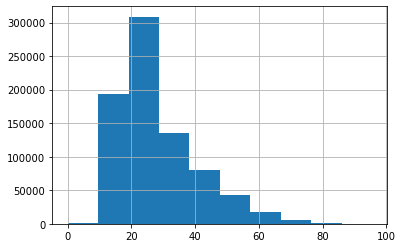

In [119]:
dfnaclean.Age.hist() # não é simetrico

Na visualização acima é possível observar que os dados não são simétricos, portanto iremos observar o log.

In [ ]:
from numpy import log10


<AxesSubplot:>

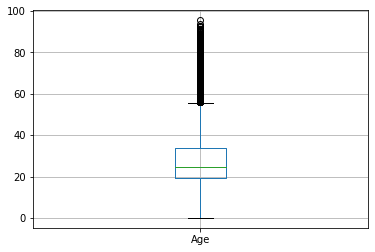

In [ ]:
dfnaclean.boxplot(column=['Age'])

In [ ]:
q1= dfnaclean['Age'].quantile(q=0.25)
q3= dfnaclean['Age'].quantile(q=0.75)
iqr= q3- q1
print(iqr)

14.5


In [ ]:
dfnaclean.shape

(775565, 23)

In [ ]:
dfnaclean = dfnaclean[(dfnaclean['Age'] < (q3 + 1.5*iqr)) 
                        &(dfnaclean['Age'] > (q1 - 1.5*iqr))]

In [ ]:
dfnaclean.shape

(745968, 23)

In [ ]:
dfnaclean['Age'].describe()

count    745968.000000
mean         26.786341
std          10.030998
min           0.000000
25%          19.000000
50%          23.500000
75%          32.500000
max          55.500000
Name: Age, dtype: float64

In [ ]:
dfcopy['Age'].describe()

count    745968.000000
mean         26.786341
std          10.030998
min           0.000000
25%          19.000000
50%          23.500000
75%          32.500000
max          55.500000
Name: Age, dtype: float64

### 3. Estatisticas descritivas dos dados e visualização

#### 3.1 Estatísticas descritivas e remoção de outliers

##### 3.1.1 Estatísticas Gerais

In [204]:
dfnaclean.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Division', 'BodyweightKg',
       'WeightClassKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg',
       'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift',
       'EquipmentC', 'DivisionC', 'WeightClassKgC', 'PlaceC', 'NameC',
       'EventC', 'Age'],
      dtype='object')

In [205]:
dfnaclean.describe()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
count,795929.000000,792827.000000,794620.000000,794632.000000,794643.000000,795929.000000,792827.000000,792827.000000,792827.000000,792062.000000,795929.000000,795929.000000,795929.000000,795929.000000,795929.000000,795929.0,795929.000000
mean,0.702151,81.888677,177.811925,115.501717,195.860997,489.093882,362.475563,361.055080,339.323178,68.589109,0.398298,1447.868428,146.851409,27.529301,244148.723227,0.0,28.155920
std,0.457341,21.882872,67.692854,49.551394,61.723131,173.085477,81.719113,81.382283,79.930931,14.617732,0.489548,590.131674,80.113791,29.582510,140445.832058,0.0,12.095259
min,0.000000,17.690000,4.700000,4.000000,7.500000,24.000000,28.360000,28.230000,27.320000,4.860000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,65.790000,125.000000,75.000000,145.000000,347.500000,307.660000,306.400000,284.430000,58.920000,0.000000,885.000000,74.000000,0.000000,124911.000000,0.0,19.500000
50%,1.000000,80.600000,175.000000,115.000000,199.600000,487.610000,360.900000,359.310000,338.230000,69.150000,0.000000,1742.000000,162.000000,32.000000,250196.000000,0.0,24.500000
75%,1.000000,94.700000,222.500000,150.000000,240.000000,610.000000,415.510000,413.730000,392.140000,78.720000,1.000000,1868.000000,216.000000,43.000000,363371.000000,0.0,34.000000
max,2.000000,260.000000,517.500000,435.000000,465.000000,1296.000000,731.310000,722.020000,691.990000,136.800000,1.000000,2428.000000,277.000000,119.000000,477323.000000,0.0,95.500000


In [206]:
dfnaclean.cov()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
Sex,0.209161,4.375785,18.220006,14.799628,18.549169,51.531814,8.445373,8.235158,13.574039,1.344852,0.017974,5.845885e+01,-3.672502,1.212523,3.936411e+02,0.0,-0.042001
BodyweightKg,4.375785,478.860084,931.127498,709.098264,857.320169,2496.713541,354.218637,326.061876,382.242961,72.514601,-0.455890,1.144743e+03,-576.659639,-15.708917,-2.356785e+04,0.0,44.646678
Best3SquatKg,18.220006,931.127498,4582.322545,3047.254293,3819.691687,11448.378154,4423.123836,4347.622004,4535.010971,712.182921,8.980837,7.055366e+03,-1125.108533,33.829064,7.718776e+04,0.0,27.242458
Best3BenchKg,14.799628,709.098264,3047.254293,2455.340611,2687.212061,8189.124045,2882.662314,2830.098117,3029.945801,471.970809,5.153690,6.155494e+03,-899.630172,11.941061,7.740615e+04,0.0,60.601536
Best3DeadliftKg,18.549169,857.320169,3819.691687,2687.212061,3809.744883,10316.087231,3747.738626,3663.764752,3906.485434,667.743648,3.021355,6.801210e+03,-886.415003,-9.192529,4.701233e+04,0.0,58.583805
TotalKg,51.531814,2496.713541,11448.378154,8189.124045,10316.087231,29958.582358,11061.602716,10849.376632,11477.744113,1853.737282,17.118464,2.000747e+04,-2908.202597,34.922929,2.025070e+05,0.0,147.303150
Dots,8.445373,354.218637,4423.123836,2882.662314,3747.738626,11061.602716,6678.013355,6638.420571,6431.181343,1084.397988,12.436597,6.580511e+03,-501.403287,-71.123574,1.828707e+05,0.0,5.816456
Wilks,8.235158,326.061876,4347.622004,2830.098117,3663.764752,10849.376632,6638.420571,6623.075917,6415.945925,1072.902565,12.644933,6.600394e+03,-628.225045,-75.534511,1.936115e+05,0.0,-0.195747
Glossbrenner,13.574039,382.242961,4535.010971,3029.945801,3906.485434,11477.744113,6431.181343,6415.945925,6388.953651,1035.751427,12.499360,7.782822e+03,-652.342356,-34.273722,1.971513e+05,0.0,-7.123583
Goodlift,1.344852,72.514601,712.182921,471.970809,667.743648,1853.737282,1084.397988,1072.902565,1035.751427,213.678082,-0.680318,9.439191e+02,-54.808000,-37.173770,1.151282e+03,0.0,6.000247


In [207]:
dfnaclean.corr()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
Sex,1.000000,0.437113,0.588408,0.652921,0.656963,0.650991,0.225911,0.221200,0.371224,0.201148,0.080282,0.216601,-0.100234,0.089622,0.006128,NaN,-0.007593
BodyweightKg,0.437113,1.000000,0.630406,0.655408,0.635598,0.660710,0.198081,0.183091,0.218535,0.227186,-0.042588,0.088631,-0.329415,-0.024257,-0.007666,NaN,0.168706
Best3SquatKg,0.588408,0.630406,1.000000,0.908472,0.914190,0.977110,0.802133,0.791694,0.840793,0.723292,0.271077,0.176625,-0.207453,0.016891,0.008118,NaN,0.033270
Best3BenchKg,0.652921,0.655408,0.908472,1.000000,0.878614,0.954785,0.713633,0.703512,0.766852,0.654059,0.212507,0.210510,-0.226606,0.008145,0.011122,NaN,0.101103
Best3DeadliftKg,0.656963,0.635598,0.914190,0.878614,1.000000,0.965626,0.744263,0.730590,0.793111,0.742972,0.100015,0.186727,-0.179249,-0.005034,0.005423,NaN,0.078463
TotalKg,0.650991,0.660710,0.977110,0.954785,0.965626,1.000000,0.783864,0.772007,0.831549,0.735642,0.202027,0.195877,-0.209728,0.006820,0.008330,NaN,0.070362
Dots,0.225911,0.198081,0.802133,0.713633,0.744263,0.783864,1.000000,0.998185,0.984583,0.910054,0.311109,0.136433,-0.076699,-0.029409,0.015929,NaN,0.005885
Wilks,0.221200,0.183091,0.791694,0.703512,0.730590,0.772007,0.998185,1.000000,0.986316,0.903826,0.317630,0.137412,-0.096497,-0.031362,0.016935,NaN,-0.000199
Glossbrenner,0.371224,0.218535,0.840793,0.766852,0.793111,0.831549,0.984583,0.986316,1.000000,0.888022,0.319675,0.164970,-0.102021,-0.014489,0.017557,NaN,-0.007369
Goodlift,0.201148,0.227186,0.723292,0.654059,0.742972,0.735642,0.910054,0.903826,0.888022,1.000000,-0.095133,0.109447,-0.046860,-0.085921,0.000561,NaN,0.033963


##### 3.1.3 Estatísticas de Peso coporal

In [149]:
dfcopy = dfnaclean.copy()

In [212]:
dfnaclean['BodyweightKg'].describe()

count    792827.000000
mean         81.888677
std          21.882872
min          17.690000
25%          65.790000
50%          80.600000
75%          94.700000
max         260.000000
Name: BodyweightKg, dtype: float64

<AxesSubplot:>

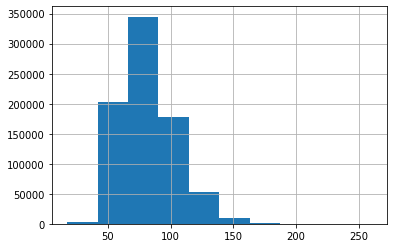

In [213]:
dfnaclean.BodyweightKg.hist()

<AxesSubplot:>

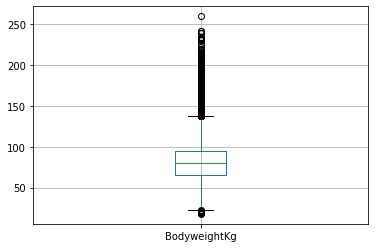

In [214]:
dfnaclean.boxplot(column=['BodyweightKg'])

In [150]:
q1= dfnaclean['BodyweightKg'].quantile(q=0.25)
q3= dfnaclean['BodyweightKg'].quantile(q=0.75)
iqr= q3- q1
print(iqr)

28.39


In [151]:
dfnaclean.shape

(745968, 23)

In [152]:
dfnaclean = dfnaclean[(dfnaclean['BodyweightKg'] < (q3 + 1.5*iqr)) 
                        &(dfnaclean['BodyweightKg'] > (q1 - 1.5*iqr))]

In [153]:
dfnaclean.shape

(733924, 23)

In [154]:
dfnaclean['BodyweightKg'].describe()

count    733924.000000
mean         80.559505
std          19.812277
min          35.000000
25%          65.600000
50%          80.060000
75%          92.700000
max         136.670000
Name: BodyweightKg, dtype: float64

In [155]:
dfcopy['BodyweightKg'].describe()

count    745968.000000
mean         81.678581
std          21.566218
min          35.000000
25%          65.710000
50%          80.450000
75%          94.100000
max         260.000000
Name: BodyweightKg, dtype: float64

##### 3.1.4 Estatísticas de peso levantado em agachamento, supino e deadlift

In [ ]:
dfcopy = dfnaclean.copy()

In [109]:
dfnaclean[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']].describe()

,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
count,794620.000000,794632.000000,794643.000000
mean,177.811925,115.501717,195.860997
std,67.692854,49.551394,61.723131
min,4.700000,4.000000,7.500000
25%,125.000000,75.000000,145.000000
50%,175.000000,115.000000,199.600000
75%,222.500000,150.000000,240.000000
max,517.500000,435.000000,465.000000


<AxesSubplot:>

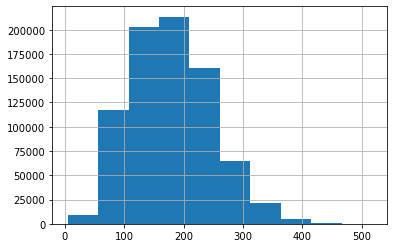

In [110]:
dfnaclean.Best3SquatKg.hist()

<AxesSubplot:>

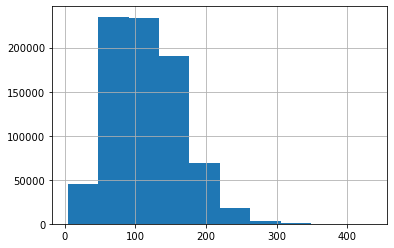

In [111]:
dfnaclean.Best3BenchKg.hist()

<AxesSubplot:>

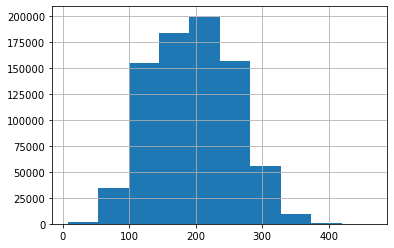

In [112]:
dfnaclean.Best3DeadliftKg.hist()

<AxesSubplot:>

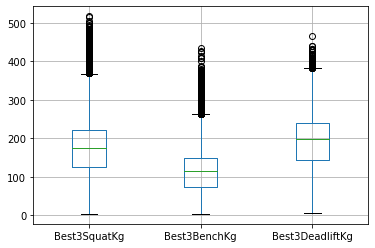

In [113]:
dfnaclean.boxplot(column=['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg'])

In [114]:
q1S = dfnaclean['Best3SquatKg'].quantile(q=0.25)
q3S = dfnaclean['Best3SquatKg'].quantile(q=0.75)
iqrS = q3S - q1S
print(iqrS)

97.5


In [115]:
q1B = dfnaclean['Best3BenchKg'].quantile(q=0.25)
q3B = dfnaclean['Best3BenchKg'].quantile(q=0.75)
iqrB = q3B - q1B
print(iqrB)

75.0


In [116]:
q1D = dfnaclean['Best3DeadliftKg'].quantile(q=0.25)
q3D = dfnaclean['Best3DeadliftKg'].quantile(q=0.75)
iqrD = q3D - q1D
print(iqrD)

95.0


In [118]:
dfnaclean.shape

(795929, 23)

In [119]:
dfnaclean = dfnaclean[(dfnaclean['Best3SquatKg'] < (q3S + 1.5*iqrS)) 
                        &(dfnaclean['Best3SquatKg'] > (q1S - 1.5*iqrS)) 
                    & (dfnaclean['Best3BenchKg'] < (q3B + 1.5*iqrB))
                        &(dfnaclean['Best3BenchKg'] > (q1B - 1.5*iqrB)) 
                    & (dfnaclean['Best3DeadliftKg'] < (q3D + 1.5*iqrD))
                        &(dfnaclean['Best3DeadliftKg'] > (q1D - 1.5*iqrD))]

In [120]:
dfnaclean.shape

(787917, 23)

In [121]:
dfnaclean[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']].describe()

,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
count,787917.000000,787917.000000,787917.000000
mean,176.226126,114.267852,194.837276
std,65.523661,47.745564,60.808624
min,4.700000,4.000000,7.500000
25%,125.000000,72.570000,145.000000
50%,172.500000,112.500000,197.500000
75%,220.000000,147.500000,240.000000
max,367.500000,262.400000,381.020000


In [ ]:
dfcopy[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']].describe()

##### 3.1.5 Estatísticas de métricas

In [122]:
dfcopy = dfnaclean.copy()

In [123]:
dfnaclean[['Dots', 'Wilks', 'Glossbrenner', 'Goodlift']].describe()

,Dots,Wilks,Glossbrenner,Goodlift
count,785119.000000,785119.000000,785119.000000,784355.000000
mean,361.086469,359.623559,337.912429,68.413719
std,80.213291,79.781992,78.381914,14.475750
min,28.360000,28.230000,27.320000,4.860000
25%,307.250000,305.990000,284.000000,58.860000
50%,360.240000,358.620000,337.520000,69.020000
75%,414.090000,412.230000,390.730000,78.490000
max,709.210000,708.690000,666.590000,136.800000


<AxesSubplot:>

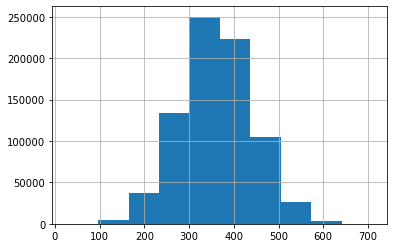

In [124]:
dfnaclean.Dots.hist()

<AxesSubplot:>

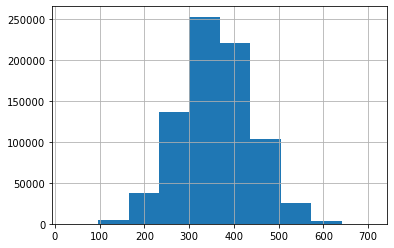

In [125]:
dfnaclean.Wilks.hist()

<AxesSubplot:>

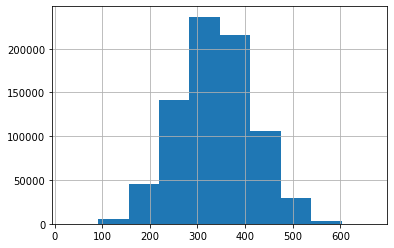

In [126]:
dfnaclean.Glossbrenner.hist()

<AxesSubplot:>

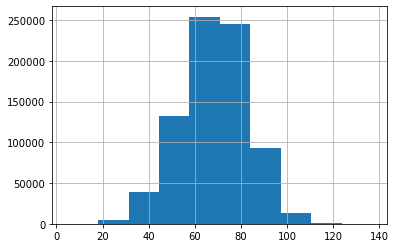

In [127]:
dfnaclean.Goodlift.hist()

<AxesSubplot:>

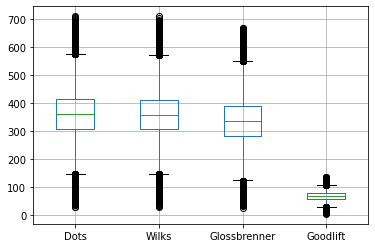

In [128]:
dfnaclean.boxplot(column=['Dots', 'Wilks', 'Glossbrenner', 'Goodlift'])

In [130]:
q1D = dfnaclean['Dots'].quantile(q=0.25)
q3D = dfnaclean['Dots'].quantile(q=0.75)
iqrD = q3D - q1D
print(iqrD)

106.83999999999997


In [131]:
q1W = dfnaclean['Wilks'].quantile(q=0.25)
q3W = dfnaclean['Wilks'].quantile(q=0.75)
iqrW = q3W - q1W
print(iqrW)

106.24000000000001


In [132]:
q1G = dfnaclean['Glossbrenner'].quantile(q=0.25)
q3G = dfnaclean['Glossbrenner'].quantile(q=0.75)
iqrG = q3G - q1G
print(iqrG)

106.73000000000002


In [133]:
q1Go = dfnaclean['Goodlift'].quantile(q=0.25)
q3Go = dfnaclean['Goodlift'].quantile(q=0.75)
iqrGo = q3Go - q1Go
print(iqrGo)

19.629999999999995


In [134]:
dfnaclean.shape

(787917, 23)

In [135]:
dfnaclean = dfnaclean[(dfnaclean['Dots'] < (q3D + 1.5*iqrD)) 
                        &(dfnaclean['Dots'] > (q1D - 1.5*iqrD)) 
                    & (dfnaclean['Wilks'] < (q3W + 1.5*iqrW))
                        &(dfnaclean['Wilks'] > (q1W - 1.5*iqrW)) 
                    & (dfnaclean['Glossbrenner'] < (q3G + 1.5*iqrG))
                        &(dfnaclean['Glossbrenner'] > (q1G - 1.5*iqrG))
                    & (dfnaclean['Goodlift'] < (q3Go + 1.5*iqrGo))
                        &(dfnaclean['Goodlift'] > (q1Go - 1.5*iqrGo))]

In [136]:
dfnaclean.shape

(775565, 23)

In [139]:
dfnaclean[['Dots', 'Wilks', 'Glossbrenner', 'Goodlift']].describe()

,Dots,Wilks,Glossbrenner,Goodlift
count,775565.000000,775565.000000,775565.000000,775565.000000
mean,361.003452,359.513013,337.845375,68.413477
std,76.855872,76.461198,75.559179,13.952134
min,147.040000,146.660000,125.030000,29.420000
25%,308.000000,306.720000,284.720000,58.960000
50%,360.210000,358.590000,337.500000,69.000000
75%,413.290000,411.430000,389.910000,78.350000
max,574.340000,571.580000,550.800000,107.920000


In [140]:
dfcopy[['Dots', 'Wilks', 'Glossbrenner', 'Goodlift']].describe()

,Dots,Wilks,Glossbrenner,Goodlift
count,785119.000000,785119.000000,785119.000000,784355.000000
mean,361.086469,359.623559,337.912429,68.413719
std,80.213291,79.781992,78.381914,14.475750
min,28.360000,28.230000,27.320000,4.860000
25%,307.250000,305.990000,284.000000,58.860000
50%,360.240000,358.620000,337.520000,69.020000
75%,414.090000,412.230000,390.730000,78.490000
max,709.210000,708.690000,666.590000,136.800000


#### 3.2 Removendo outliers usando razão de duas variáveis

In [165]:
dfcopy = dfnaclean.copy()

<AxesSubplot:xlabel='BodyweightKg', ylabel='TotalKg'>

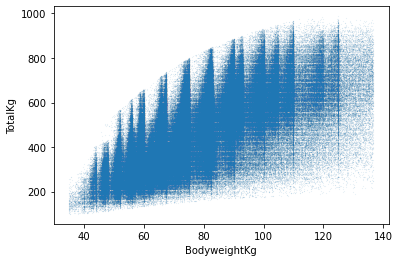

In [164]:
dfnaclean.plot.scatter(x='BodyweightKg',y='TotalKg', s=.001)

In [167]:
dfnaclean['total_bodyweight'] = dfnaclean['TotalKg']/dfnaclean['BodyweightKg']

<AxesSubplot:>

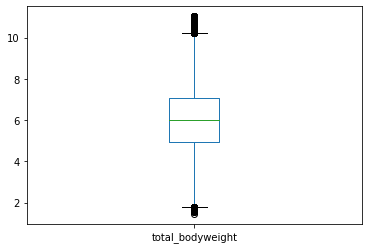

In [168]:
dfnaclean['total_bodyweight'].plot.box()

In [170]:
dfnaclean['total_bodyweight'].describe()

count    733924.000000
mean          6.029721
std           1.519022
min           1.454824
25%           4.956140
50%           6.023166
75%           7.052023
max          11.024765
Name: total_bodyweight, dtype: float64

<AxesSubplot:>

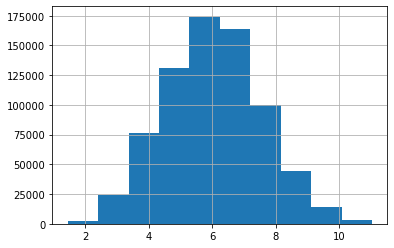

In [169]:
dfnaclean['total_bodyweight'].hist()

In [172]:
q1 = dfnaclean['total_bodyweight'].quantile(q=0.25)
q3 = dfnaclean['total_bodyweight'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)

2.095882770510091


In [173]:
dfnaclean.shape

(733924, 24)

In [174]:
dfnaclean = dfnaclean[(dfnaclean['total_bodyweight'] < (q3 + 1.5*iqr)) 
                        &(dfnaclean['total_bodyweight'] > (q1 - 1.5*iqr)) 
                    ]

In [175]:
dfnaclean.shape

(731331, 24)

In [176]:
dfnaclean['total_bodyweight'].describe()

count    731331.000000
mean          6.014841
std           1.498318
min           1.813187
25%           4.951923
50%           6.016598
75%           7.039397
max          10.195155
Name: total_bodyweight, dtype: float64

In [177]:
dfcopy['total_bodyweight'].describe()

KeyError: 'total_bodyweight'

#### 3.3 Comparando com outro método de remoção de outliers (STAND BY)

In [141]:
codes = ['Equipment', 'Division', 'WeightClassKg', 'Place', 'Name', 'Event', 'NameC', 'EventC']
dfclean = dfnaclean.drop(codes, axis = 1).dropna()
dfclean.dtypes

Sex                   int8
BodyweightKg       float64
Best3SquatKg       float64
Best3BenchKg       float64
Best3DeadliftKg    float64
TotalKg            float64
Dots               float64
Wilks              float64
Glossbrenner       float64
Goodlift           float64
EquipmentC            int8
DivisionC            int16
WeightClassKgC       int16
PlaceC                int8
Age                float64
dtype: object

In [237]:
from sklearn.ensemble import IsolationForest
isolFor = IsolationForest(max_samples=100, random_state=42)
isolFor.fit(dfclean)

IsolationForest(max_samples=100, random_state=42)

In [238]:
dfclean['outlierIsol'] = isolFor.predict(dfclean)

In [239]:
dfclean[dfclean['outlierIsol'] != -1].drop('outlierIsol', axis=1).corr()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,Age
Sex,1.000000,0.390996,0.644353,0.706850,0.704756,0.716045,0.259845,0.264488,0.454700,0.182293,0.145235,0.203877,-0.097337,0.126343,0.002909
BodyweightKg,0.390996,1.000000,0.595980,0.613623,0.611954,0.635716,0.086494,0.064160,0.105076,0.154484,-0.080098,0.103525,-0.394377,-0.007382,0.169041
Best3SquatKg,0.644353,0.595980,1.000000,0.867517,0.880278,0.964756,0.745488,0.732534,0.795614,0.608291,0.290427,0.192601,-0.181358,0.050818,0.042333
Best3BenchKg,0.706850,0.613623,0.867517,1.000000,0.841921,0.938952,0.640177,0.629197,0.713746,0.544968,0.210047,0.219510,-0.207326,0.045077,0.115693
Best3DeadliftKg,0.704756,0.611954,0.880278,0.841921,1.000000,0.955326,0.672741,0.658946,0.740058,0.649618,0.099263,0.185572,-0.172062,0.034360,0.085379
TotalKg,0.716045,0.635716,0.964756,0.938952,0.955326,1.000000,0.723357,0.710055,0.789158,0.634009,0.210186,0.207223,-0.194327,0.045500,0.081921
Dots,0.259845,0.086494,0.745488,0.640177,0.672741,0.723357,1.000000,0.997540,0.972653,0.833171,0.336379,0.147039,-0.001049,-0.019455,0.003217
Wilks,0.264488,0.064160,0.732534,0.629197,0.658946,0.710055,0.997540,1.000000,0.977650,0.825662,0.340575,0.148567,-0.020248,-0.022076,-0.004844
Glossbrenner,0.454700,0.105076,0.795614,0.713746,0.740058,0.789158,0.972653,0.977650,1.000000,0.792385,0.350381,0.177643,-0.028399,0.007408,-0.011346
Goodlift,0.182293,0.154484,0.608291,0.544968,0.649618,0.634009,0.833171,0.825662,0.792385,1.000000,-0.228408,0.076182,-0.000377,-0.074448,0.040498


In [158]:
dfnaclean.describe()

,Sex,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift,EquipmentC,DivisionC,WeightClassKgC,PlaceC,NameC,EventC,Age
count,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.000000,733924.0,733924.000000
mean,0.694492,80.559505,176.360682,113.989610,195.061361,485.411106,363.321209,361.652970,339.803632,68.845081,0.391644,1439.417008,149.165780,28.422448,243305.604000,0.0,26.730933
std,0.460652,19.812277,63.772570,46.905635,59.740482,164.800624,76.268484,75.775083,75.064162,13.838760,0.488118,596.492546,79.541971,29.757133,140567.899808,0.0,10.024232
min,0.000000,35.000000,12.500000,7.260000,7.500000,100.000000,147.040000,146.660000,126.290000,29.420000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,65.600000,125.000000,73.000000,145.000000,347.500000,310.800000,309.400000,287.127500,59.540000,0.000000,885.000000,102.000000,0.000000,124148.750000,0.0,19.000000
50%,1.000000,80.060000,175.000000,112.500000,197.500000,487.500000,362.410000,360.630000,339.465000,69.460000,0.000000,1756.000000,162.000000,32.000000,249376.000000,0.0,23.500000
75%,1.000000,92.700000,220.000000,147.500000,240.000000,607.500000,415.020000,412.990000,391.440000,78.680000,1.000000,1868.000000,216.000000,43.000000,362128.000000,0.0,32.500000
max,2.000000,136.670000,367.500000,261.000000,381.020000,987.500000,574.340000,571.580000,550.800000,107.920000,1.000000,2428.000000,277.000000,119.000000,477323.000000,0.0,55.500000


#### 3.4 Discretizando peso corporal

In [178]:
dfnaclean['BodyweightKg_dist'] = pd.qcut(dfnaclean['BodyweightKg'], 5)

<ipython-input-178-024c1bd008e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfnaclean['BodyweightKg_dist'] = pd.qcut(dfnaclean['BodyweightKg'], 5)


In [179]:
dfnaclean['BodyweightKg_dist'].describe()

count            731331
unique                5
top       (82.96, 98.4]
freq             146848
Name: BodyweightKg_dist, dtype: object

In [180]:
dfnaclean['BodyweightKg_dist'].value_counts()

(82.96, 98.4]     146848
(34.999, 62.3]    146689
(62.3, 73.6]      146222
(73.6, 82.96]     145913
(98.4, 136.67]    145659
Name: BodyweightKg_dist, dtype: int64

### 4. Hipóteses e testes de hipótese

##### Hipótese 1

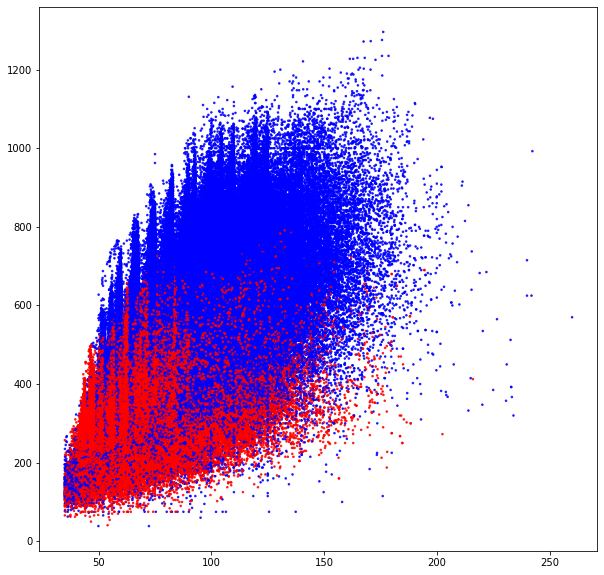

In [287]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

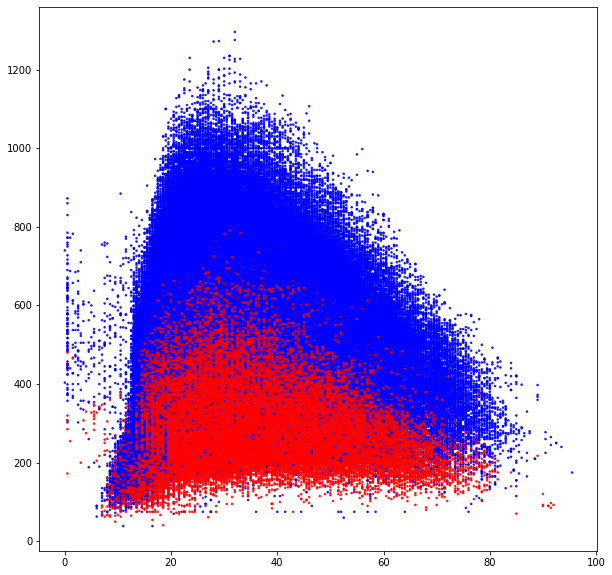

In [288]:
## peso total por idade, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['Age'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

In [336]:
def get_plot_and_stats(bincategory, column, samples=50):
    df1 = dfclean[dfclean[bincategory] == 1]
    df0 = dfclean[dfclean[bincategory] == 0]
    df0_sample = df0[column].sample(n=samples)
    df1_sample = df1[column].sample(n=samples)
    print("Full data histogram:")
    df0[column].hist()
    df1[column].hist()
    plt.show()
    print("#####################################################")
    print()
    print("Category 0: " + str(stats.shapiro(df0_sample)))
    print("Category 1: " + str(stats.shapiro(df1_sample)))
    print(stats.ttest_ind(df1_sample, df0_sample))
    print(stats.mannwhitneyu(df0_sample, df0_sample))
    print()
    print("#####################################################")
    print("Sampled data histogram:")
    df0_sample.hist()
    df1_sample.hist()
    plt.show()


Full data histogram:


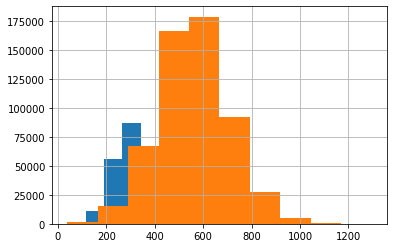

#####################################################

Category 0: ShapiroResult(statistic=0.9815587401390076, pvalue=0.6193113327026367)
Category 1: ShapiroResult(statistic=0.9910993576049805, pvalue=0.9683601260185242)
Ttest_indResult(statistic=10.244871142117399, pvalue=3.5619537303732797e-17)
MannwhitneyuResult(statistic=1250.0, pvalue=0.4986244140360294)

#####################################################
Sampled data histogram:


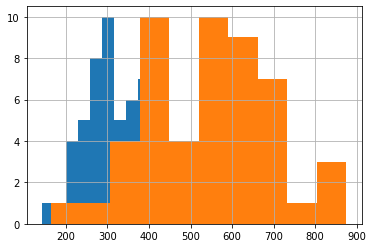

In [337]:
get_plot_and_stats('Sex', 'TotalKg')

Full data histogram:


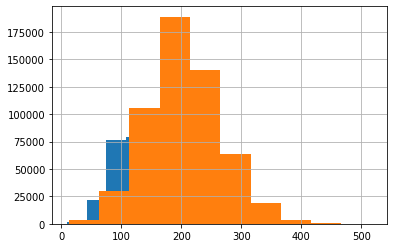

#####################################################

Category 0: ShapiroResult(statistic=0.9665079116821289, pvalue=0.1662946194410324)
Category 1: ShapiroResult(statistic=0.9504738450050354, pvalue=0.03567994758486748)
Ttest_indResult(statistic=8.449411166088902, pvalue=2.762632134829046e-13)
MannwhitneyuResult(statistic=1250.0, pvalue=0.49862259323628205)

#####################################################
Sampled data histogram:


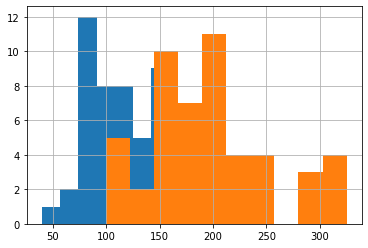

In [338]:
get_plot_and_stats('Sex','Best3SquatKg')

Full data histogram:


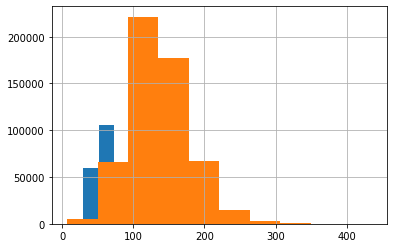

#####################################################

Category 0: ShapiroResult(statistic=0.9884264469146729, pvalue=0.9027171730995178)
Category 1: ShapiroResult(statistic=0.9579146504402161, pvalue=0.07269833981990814)
Ttest_indResult(statistic=11.090612622082686, pvalue=5.293706316954811e-19)
MannwhitneyuResult(statistic=1250.0, pvalue=0.4986223277898952)

#####################################################
Sampled data histogram:


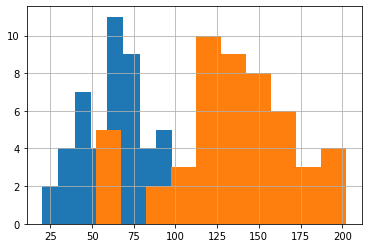

In [339]:
get_plot_and_stats('Sex','Best3BenchKg')

Full data histogram:


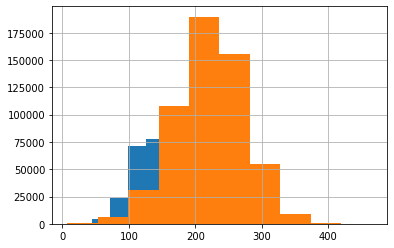

#####################################################

Category 0: ShapiroResult(statistic=0.9763907790184021, pvalue=0.41169318556785583)
Category 1: ShapiroResult(statistic=0.9701905846595764, pvalue=0.2356104701757431)
Ttest_indResult(statistic=12.410514234409286, pvalue=8.111766140619514e-22)
MannwhitneyuResult(statistic=1250.0, pvalue=0.4986237527627923)

#####################################################
Sampled data histogram:


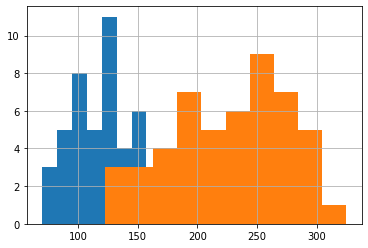

In [340]:
get_plot_and_stats('Sex','Best3DeadliftKg')

##### Hipótese 2

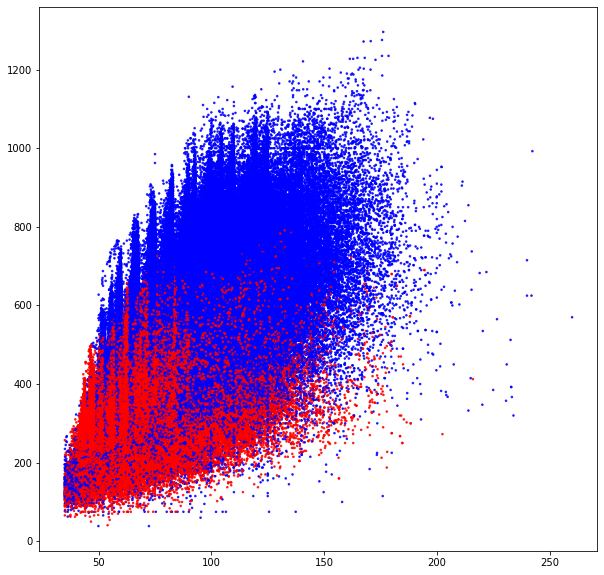

In [342]:
## peso total por peso corporal, separado por genero
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['Sex']])

Full data histogram:


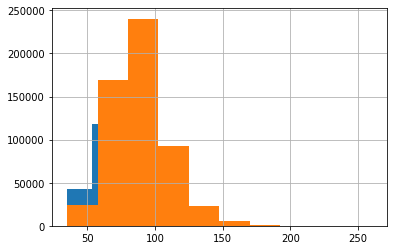

#####################################################

Category 0: ShapiroResult(statistic=0.8864728212356567, pvalue=0.00017693970585241914)
Category 1: ShapiroResult(statistic=0.9558121562004089, pvalue=0.05938591808080673)
Ttest_indResult(statistic=6.609374137607675, pvalue=2.0269561609349565e-09)
MannwhitneyuResult(statistic=1250.0, pvalue=0.498624579205454)

#####################################################
Sampled data histogram:


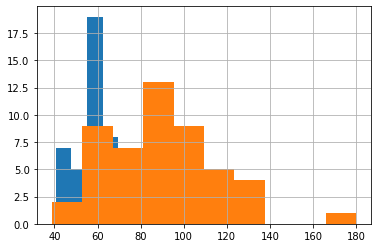

In [341]:
get_plot_and_stats('Sex','BodyweightKg')

##### Hipótese 3

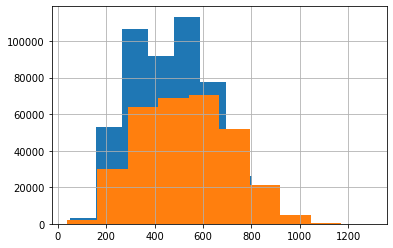

ShapiroResult(statistic=0.9798792600631714, pvalue=0.5468817949295044)
ShapiroResult(statistic=0.9737975001335144, pvalue=0.3279985189437866)
Ttest_indResult(statistic=2.595253616773597, pvalue=0.010903303915067195)
MannwhitneyuResult(statistic=1250.0, pvalue=0.49862451314482403)


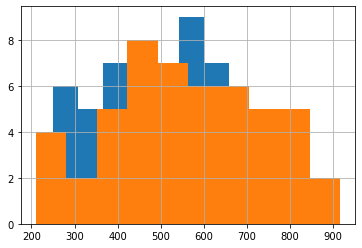

In [326]:
get_plot_and_stats('EquipmentC','TotalKg')

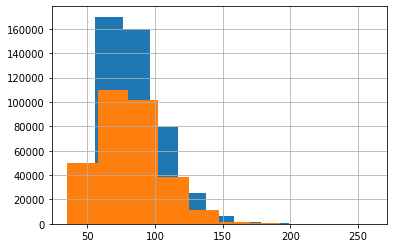

ShapiroResult(statistic=0.9272039532661438, pvalue=0.004337735939770937)
ShapiroResult(statistic=0.9408004283905029, pvalue=0.014493277296423912)
Ttest_indResult(statistic=-1.9723285544368656, pvalue=0.05139034283547983)
MannwhitneyuResult(statistic=1250.0, pvalue=0.4986246452565667)


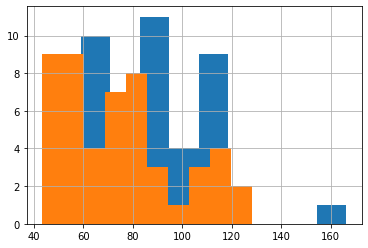

In [327]:
get_plot_and_stats('EquipmentC','BodyweightKg')

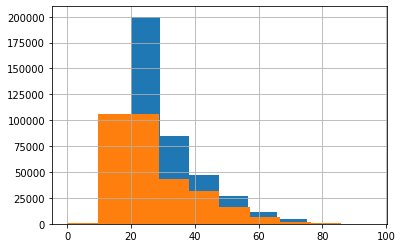

ShapiroResult(statistic=0.8418817520141602, pvalue=9.393992513651028e-06)
ShapiroResult(statistic=0.8932567238807678, pvalue=0.00028991044382564723)
Ttest_indResult(statistic=0.12638524061455148, pvalue=0.8996859232769863)
MannwhitneyuResult(statistic=1250.0, pvalue=0.49862371967409175)


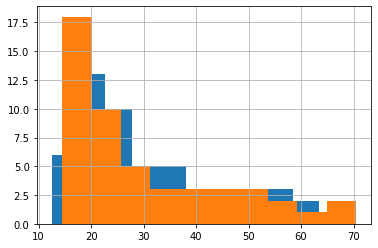

In [328]:
get_plot_and_stats('EquipmentC','Age')

Full data histogram:


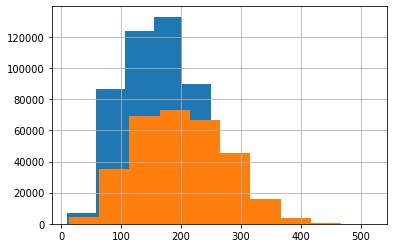

#####################################################

Category 0: ShapiroResult(statistic=0.9836393594741821, pvalue=0.7119089961051941)
Category 1: ShapiroResult(statistic=0.9620562195777893, pvalue=0.10840504616498947)
Ttest_indResult(statistic=3.483600035104739, pvalue=0.0007411033598194296)
MannwhitneyuResult(statistic=1250.0, pvalue=0.4986240835185902)

#####################################################
Sampled data histogram:


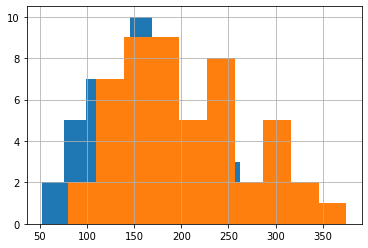

In [343]:
get_plot_and_stats('EquipmentC','Best3SquatKg')

Full data histogram:


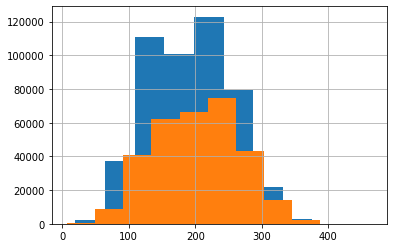

#####################################################

Category 0: ShapiroResult(statistic=0.9647237062454224, pvalue=0.14016036689281464)
Category 1: ShapiroResult(statistic=0.978551983833313, pvalue=0.49264219403266907)
Ttest_indResult(statistic=1.0817248112054074, pvalue=0.2820294521141337)
MannwhitneyuResult(statistic=1250.0, pvalue=0.49862428185763846)

#####################################################
Sampled data histogram:


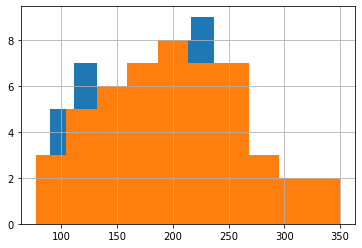

In [344]:
get_plot_and_stats('EquipmentC','Best3DeadliftKg')

Full data histogram:


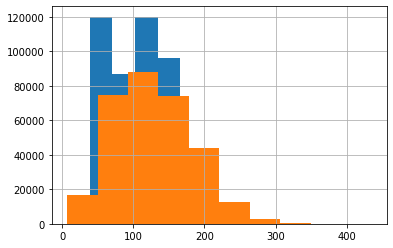

#####################################################

Category 0: ShapiroResult(statistic=0.9829918146133423, pvalue=0.683030903339386)
Category 1: ShapiroResult(statistic=0.9748594760894775, pvalue=0.3604653477668762)
Ttest_indResult(statistic=0.6633270625417337, pvalue=0.5086784585037504)
MannwhitneyuResult(statistic=1250.0, pvalue=0.498623918170504)

#####################################################
Sampled data histogram:


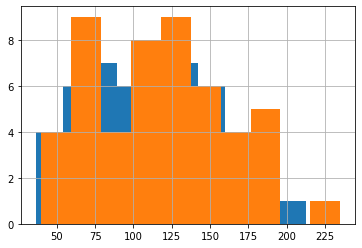

In [345]:
get_plot_and_stats('EquipmentC','Best3BenchKg')

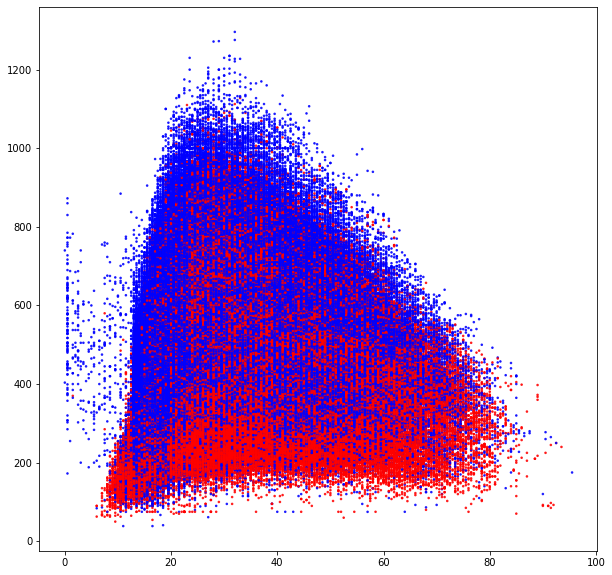

In [141]:
## peso total por idade, separado por equipamento
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['Age'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['EquipmentC']])

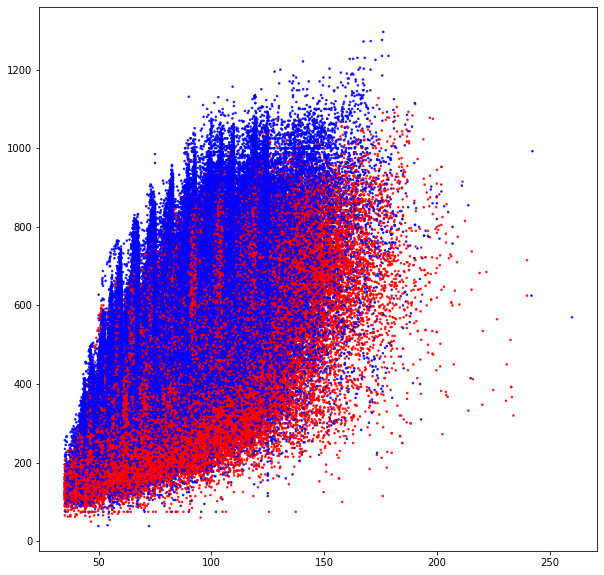

In [142]:
## peso total por peso corporal, separado por equipamento
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['TotalKg'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['EquipmentC']])

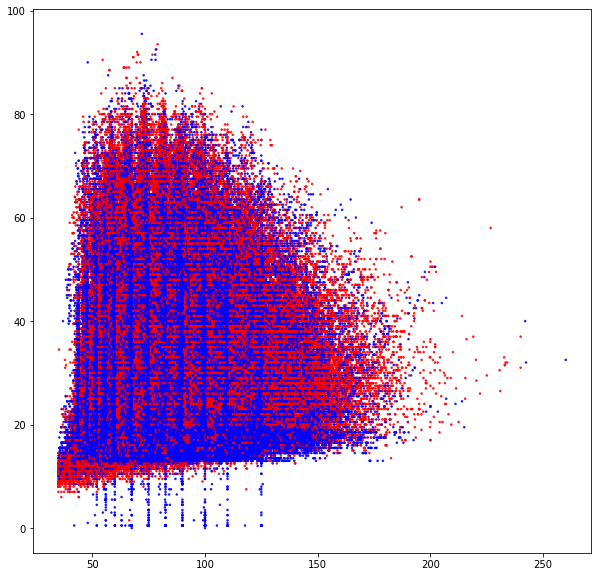

In [143]:
## peso total por peso corporal, separado por equipamento
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(dfclean['BodyweightKg'], dfclean['Age'], alpha=0.8, s=2.5,
           c=['r' if x == 0 else 'b' for x in dfclean['EquipmentC']])